# LSTM trained for Anomaly Detection in Time-Series Data
This example creates an LSTM in Tensorflow for the purpose of detecting anomalies in time series data.
The model is trained with sinusoidal data plus noise (normal case). Random spikes are added to generate anomalies.
The trained model is then saved, quantized to int8 and converted to .tflite format.

Finally, inference is run with the original fp32 model and the quantized .tflite model to determine the difference in accuracy.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib
import os
import matplotlib.pyplot as plt
import random

2025-06-23 11:46:35.633386: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-23 11:46:35.643584: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-23 11:46:35.668050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750671995.720739 3009813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750671995.732791 3009813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750671995.757378 3009813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Constants

In [2]:
SEED=42 
random.seed(SEED) 

UNROLL = False  # Use dynamic unrolling for LSTM

if UNROLL:
    model_file = "lstm_model_unrolled_fp32.keras"
    tflite_file = "lstm_model_unrolled_int8_quantized.tflite"
else:
    model_file = "lstm_model_fp32.keras"
    tflite_file = "lstm_model_int8_quantized.tflite"
    
FEATURES = 1
SEQ_LEN = 100
TRAINING_BATCH_SIZE = 8
INFERENCE_BATCH_SIZE = 1
NUM_SAMPLES = 1000  # Increased for better generalization
HIDDEN_UNITS = 32   # Reduced to prevent overfitting

# suppress warnings
import logging
import time
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = filter INFO, 2 = +WARNING, 3 = ERROR only

## Prepare training data
### Generate synthetic time-series data for anomaly detection

In [3]:
X = np.zeros((NUM_SAMPLES, SEQ_LEN, FEATURES), dtype=np.float32)
y = np.zeros((NUM_SAMPLES, 1), dtype=np.float32)

for i in range(NUM_SAMPLES):

    # Normal: smooth sinusoidal pattern with noise
    t = np.linspace(0, 8 * np.pi, SEQ_LEN)
    series = np.sin(t) + 0.1 * np.random.normal(0, 0.2, size=SEQ_LEN)
    label = 0.0
    
    if i % 3 == 0:
        # inject spikes anomaly for 30 percent of samples
        # random nbumber of spikes between 1 and 5
        num_spikes = np.random.randint(1, 6)
        spike_indices = np.random.choice(SEQ_LEN, size=num_spikes, replace=False)
        # random spike magnitude between 1 and 5
        series[spike_indices] += np.random.uniform(1, 6, size=num_spikes)
        label = 1.0

    X[i, :, 0] = series
    y[i, 0] = label

### Normalize input data to improve training stability

In [4]:
X = (X - np.mean(X)) / np.std(X)

### Split data into train/val/test
70% train, 15% validation, 15% test

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

### Save test data to files for C++ use

In [6]:
print("Saving test data to files for C++ inference run use...")
np.savetxt("X_test.txt", X_test.reshape(X_test.shape[0], -1), delimiter=' ')
np.savetxt("y_test.txt", y_test, delimiter=' ')

Saving test data to files for C++ inference run use...


## Load or create/train the model

In [7]:
print("\n## Loading or creating the LSTM model...")
if os.path.exists(model_file):
    print(f"Loading existing model from {model_file}")
    model = tf.keras.models.load_model(model_file)
else:
    # Define the model with regularization
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(SEQ_LEN, FEATURES)),
        tf.keras.layers.LSTM(HIDDEN_UNITS, unroll=UNROLL, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    print("No existing model found. A new model will be created.")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=TRAINING_BATCH_SIZE,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    # save trained model
    print("Training complete. Saving the model as ", model_file)
    model.save(model_file)

    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Crossentropy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()   


## Loading or creating the LSTM model...
Loading existing model from lstm_model_fp32.keras


2025-06-23 11:46:38.719283: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Evaluate on test data

In [8]:
print("\n## Evaluating the model on test data")
loss, accuracy = model.evaluate(X_test, y_test, batch_size=INFERENCE_BATCH_SIZE)
print(f"FP32 Test Accuracy from evaluate: {accuracy:.8f}, Loss: {loss:.8f}")

fp32_preds = model.predict(X_test, batch_size=INFERENCE_BATCH_SIZE)

# double check accuracy
fp32_preds_rounded = (fp32_preds > 0.5).astype(np.float32)
fp32_accuracy = np.mean(fp32_preds_rounded.flatten() == y_test.flatten())
print(f"FP32 Model Test Accuracy from predict: {fp32_accuracy:.8f}")


## Evaluating the model on test data
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8342 - loss: 0.4271
FP32 Test Accuracy from evaluate: 0.87333333, Loss: 0.35454160
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
FP32 Model Test Accuracy from predict: 0.87333333


## Visualise some predictions

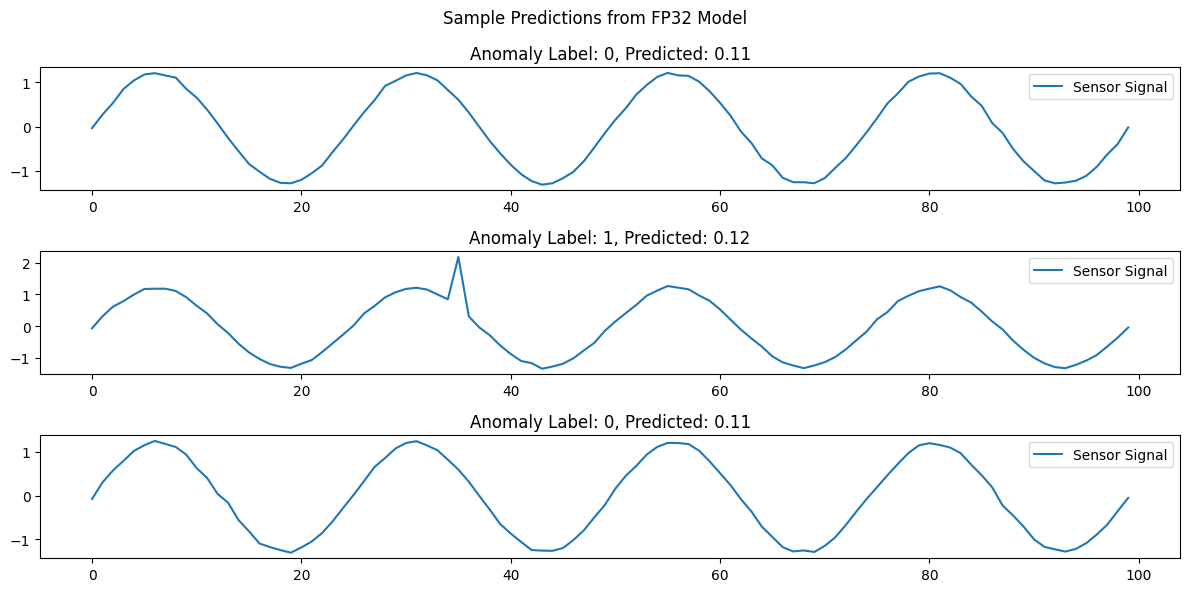

In [9]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 6))
fig.suptitle("Sample Predictions from FP32 Model")

for i, ax in enumerate(axes):
    ax.plot(X_test[i].squeeze(), label='Sensor Signal')
    ax.set_title(f"Anomaly Label: {int(y_test[i][0])}, Predicted: {fp32_preds[i][0]:.2f}")
    ax.legend()

plt.tight_layout()
plt.show()

## Quantize and convert to the TFLite format

In [10]:
print("\n## Quantize and convert to the TFLite format")
# Quantization representative dataset
def representative_dataset():
    for i in range(100):
        yield [X_train[i:i+1]]

# Convert to quantized TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

if not UNROLL:
    converter.target_spec.supported_ops.append(tf.lite.OpsSet.SELECT_TF_OPS)
    converter._experimental_lower_tensor_list_ops = False

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Save quantized model
tflite_model = converter.convert()
pathlib.Path(tflite_file).write_bytes(tflite_model)
print(f"INT8-quantized model saved as {tflite_file}")


## Quantize and convert to the TFLite format
Saved artifact at '/tmp/tmp7g6jje5r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140501690329488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140501690329296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140501690329680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140501690329872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140501690332752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140501690332944: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/tgmeinde/NeuralBoost/LSTM_anomaly_detection/py3.12/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1750672009.800062 3009813 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750672009.800225 3009813 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-23 11:46:49.802444: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7g6jje5r
2025-06-23 11:46:49.804836: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-23 11:46:49.804869: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp7g6jje5r
I0000 00:00:1750672009.852572 3009813 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-06-23 11:46:49.856102: I tensorflow/cc/saved_model/loader.cc:236] Restoring Saved

INT8-quantized model saved as lstm_model_int8_quantized.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


## Evaluate TFLite model

In [11]:
print("\n## Evaluating the INT8 TFLite model")
interpreter = tf.lite.Interpreter(model_path=tflite_file)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def run_tflite_model(interpreter, X):

    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    preds = []
    times = []
    for i in range(len(X)):
        x = X[i:i+1]
        x_int8 = np.round(x / input_scale + input_zero_point).astype(np.int8)

        start_time = time.time()
        interpreter.set_tensor(input_details[0]['index'], x_int8)
        interpreter.invoke()
        end_time = time.time()

        times.append(end_time - start_time)

        output = interpreter.get_tensor(output_details[0]['index'])
        output = (output.astype(np.float32) - output_zero_point) * output_scale
        preds.append(output[0])

    mean_time = sum(times) / len(times)
    print(f"Mean tflite inference time: {mean_time:.6f} seconds")
    return np.array(preds)

int8_preds = run_tflite_model(interpreter, X_test)
int8_preds = (int8_preds > 0.5).astype(np.float32)
int8_accuracy = np.mean(int8_preds.flatten() == y_test.flatten())
print(f"INT8 Quantized Model Test Accuracy: {int8_accuracy:.8f}")

/home/tgmeinde/NeuralBoost/LSTM_anomaly_detection/py3.12/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



## Evaluating the INT8 TFLite model
Mean tflite inference time: 0.001814 seconds
INT8 Quantized Model Test Accuracy: 0.86666667


## Compare accuracy of FP32 and INT8 models

In [12]:
print("\n## Comparing accuracy of FP32 and INT8 models")
print(f"FP32 Test Accuracy: {accuracy:.8f}")
print(f"INT8 Quantized Model Test Accuracy: {int8_accuracy:.8f}")
# accuracy difference should be minimal, around 1-2% loss in accuracy
print(f"Difference in accuracy: {accuracy - int8_accuracy:.8f}") 
# print hyperparameters
print(f"Hyperparameters: UNROLL={UNROLL}, FEATURES={FEATURES}, SEQ_LEN={SEQ_LEN}, "
      f"TRAINING_BATCH_SIZE={TRAINING_BATCH_SIZE}, INFERENCE_BATCH_SIZE={INFERENCE_BATCH_SIZE}, "
      f"NUM_SAMPLES={NUM_SAMPLES}, HIDDEN_UNITS={HIDDEN_UNITS}")


## Comparing accuracy of FP32 and INT8 models
FP32 Test Accuracy: 0.87333333
INT8 Quantized Model Test Accuracy: 0.86666667
Difference in accuracy: 0.00666667
Hyperparameters: UNROLL=False, FEATURES=1, SEQ_LEN=100, TRAINING_BATCH_SIZE=8, INFERENCE_BATCH_SIZE=1, NUM_SAMPLES=1000, HIDDEN_UNITS=32
